# Example notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pertpy
from deres import DEResult
import scanpy as sc
import numpy as np
import pandas as pd

/home/sturm/projects/scverse/deres/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.datasets.pbmc3k_processed()

In [4]:
adata.obs["sample"] = pd.Categorical(np.random.randint(0, 10, adata.shape[0]))
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

In [5]:
adata.obs

,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,7
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,2
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,9
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,2
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,8
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,6
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,2
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,6


In [6]:
pb = sc.get.aggregate(adata, ["sample", "louvain"], "mean")

In [7]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'sample'
    var: 'n_cells'

In [8]:
pb.layers["mean"]

array([[0.        , 0.        , 0.        , ..., 0.00572849, 0.05490735,
        0.00572849],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01540327,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.06931472,
        0.        ],
       [0.        , 0.        , 0.13862944, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
mod = pertpy.tl.Statsmodels(pb, design="~ louvain", layer="mean")
mod.fit()

100%|██████████| 13714/13714 [00:11<00:00, 1198.73it/s]


In [22]:
res = mod.test_contrasts(
    {
        "CD8_vs_CD4": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="CD4 T cells"),
        "CD8_vs_NK": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="NK cells"),
    }
)
res["p_value"] = res["p_value"].astype(float)  # don't ask me why this is an object column

100%|██████████| 13714/13714 [00:01<00:00, 12073.40it/s]


In [23]:
res

,variable,p_value,t_value,sd,log_fc,adj_p_value,contrast
11083,CCL5,1.226836e-31,2.057556e+01,0.087701,1.804491e+00,1.226836e-31,CD8_vs_CD4
13001,NKG7,2.175566e-31,2.038280e+01,0.086376,1.760584e+00,2.175566e-31,CD8_vs_CD4
3694,GZMK,5.676208e-31,2.006299e+01,0.035636,7.149595e-01,5.676208e-31,CD8_vs_CD4
3695,GZMA,5.991939e-28,1.784392e+01,0.046801,8.351210e-01,5.991939e-28,CD8_vs_CD4
7873,CTSW,4.239498e-27,1.725073e+01,0.042210,7.281525e-01,4.239498e-27,CD8_vs_CD4
...,...,...,...,...,...,...,...
8340,CLECL1,1.000000e+00,3.717855e-17,0.005832,2.168404e-19,1.000000e+00,CD8_vs_NK
12941,DHDH,1.000000e+00,1.033068e-16,0.002099,2.168404e-19,1.000000e+00,CD8_vs_NK
6870,C9orf96,1.000000e+00,7.557508e-17,0.005738,4.336809e-19,1.000000e+00,CD8_vs_NK
12936,HSD17B14,1.000000e+00,0.000000e+00,0.001512,0.000000e+00,1.000000e+00,CD8_vs_NK


In [54]:
de_res = DEResult(
    res, pb, p_col="p_value", effect_size_col="log_fc", var_col="variable", contrast_col="contrast", layer="mean"
)

In [55]:
de_res.summary()

,total,up,down,contrast
p < 0.1,1072,427,645,CD8_vs_CD4
p < 0.05,790,281,509,CD8_vs_CD4
p < 0.01,476,131,345,CD8_vs_CD4
p < 0.001,288,71,217,CD8_vs_CD4
p < 0.0001,163,49,114,CD8_vs_CD4
p < 0.1,1869,915,954,CD8_vs_NK
p < 0.05,1168,586,582,CD8_vs_NK
p < 0.01,687,352,335,CD8_vs_NK
p < 0.001,353,182,171,CD8_vs_NK
p < 0.0001,233,123,110,CD8_vs_NK


In [56]:
de_res.p_adjust()

In [57]:
de_res.summary()

,total,up,down,contrast
p < 0.1,348,91,257,CD8_vs_CD4
p < 0.05,298,73,225,CD8_vs_CD4
p < 0.01,173,53,120,CD8_vs_CD4
p < 0.001,127,41,86,CD8_vs_CD4
p < 0.0001,68,31,37,CD8_vs_CD4
p < 0.1,455,234,221,CD8_vs_NK
p < 0.05,363,187,176,CD8_vs_NK
p < 0.01,247,129,118,CD8_vs_NK
p < 0.001,170,84,86,CD8_vs_NK
p < 0.0001,118,55,63,CD8_vs_NK


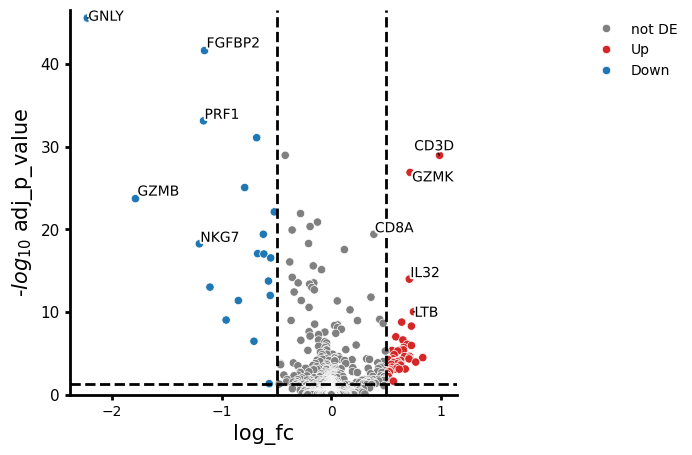

In [58]:
de_res.plot_volcano("CD8_vs_NK", log2fc_thresh=0.5)

Index(['CD8 T cells', 'NK cells'], dtype='object')


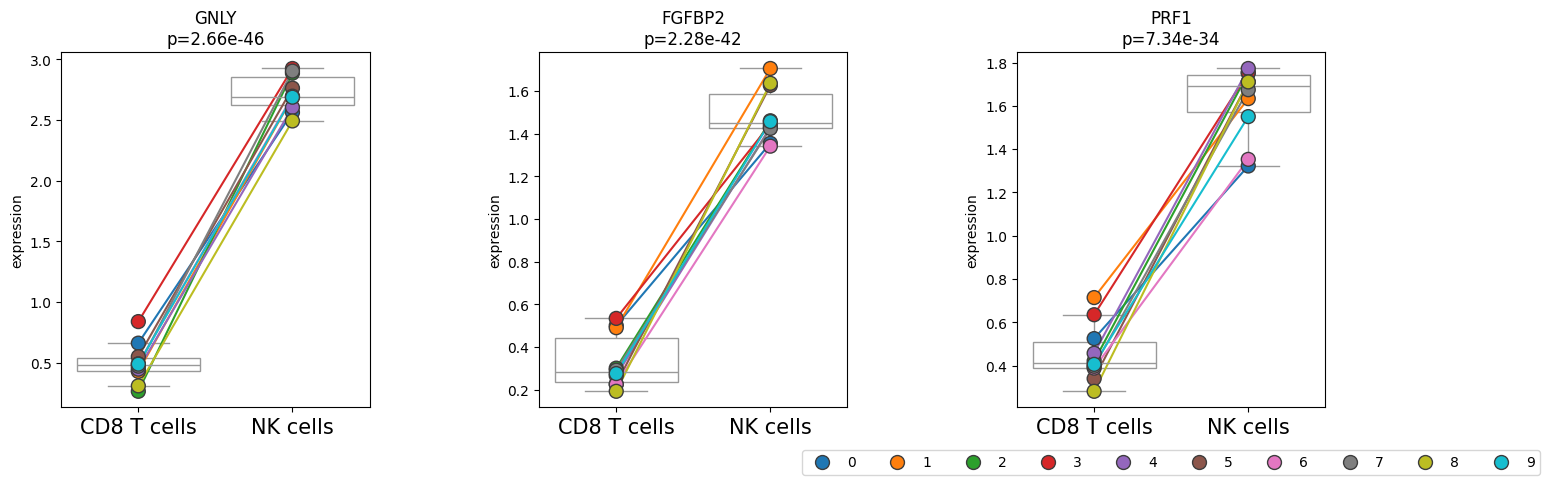

In [61]:
de_res.plot_paired("louvain", "sample", "CD8_vs_NK", groups=["CD8 T cells", "NK cells"], n_top_vars=3)

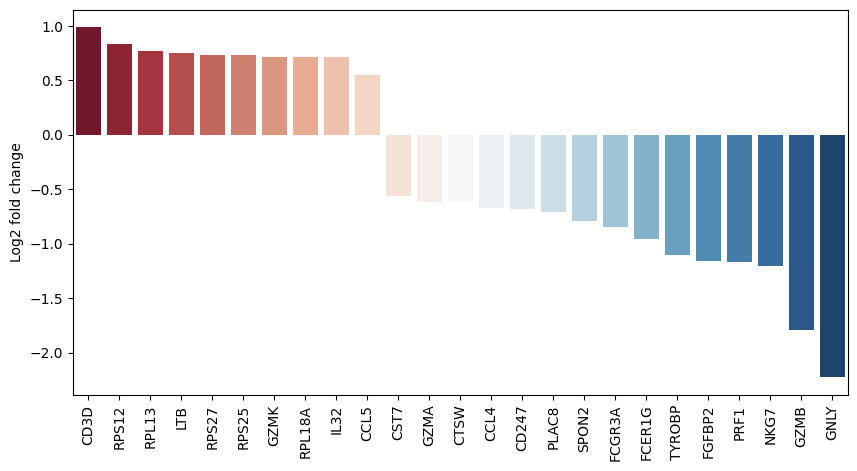

In [36]:
de_res.plot_fold_change("CD8_vs_NK")

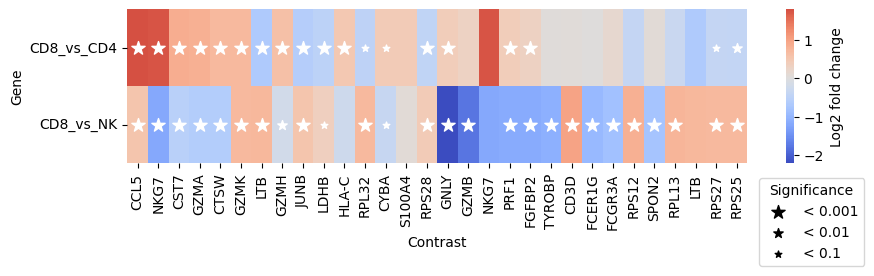

In [37]:
de_res.plot_multicomparison_fc()